In [ ]:
#Download all libarys(except ML) and upload file into colab and make them .csv
import pandas as pd
from google.colab import files
import io
import seaborn as sns
import matplotlib.pyplot as plt
import re
uploaded_train = files.upload()
uploaded_test = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


In [ ]:
#Prepare our df to fill na in Age. Group people 
def make_group(name):
  group_name = re.findall(r'[A-Z][a-z]+\.', name)[0]
  temp2=['Mr.','Miss.','Mrs.','Master.']
  return group_name if group_name in temp2 else 'Other'

#Put median depends on previous group  
def fill_na_age(df):
  df = df.merge(temp,on='Name')
  df = pd.get_dummies(df,columns=['Name'],drop_first=True)
  df.Age = df.fillna(0).apply(lambda x:round(x.Median) if x.Age == 0 else round(x.Age), axis=1)
  df = df.drop(columns=['Median'])
  return df

#Test represent,that use this function useless.Reason: underfitting
# def cat_series(df):
#   df.Age=df.apply(lambda x:round(x.Age/10),axis=1)
#   df = pd.get_dummies(df,columns=['Age'],drop_first = True)
#   return df

#Some preparation and Make equallity our Train and Test dataFrame
def make_eq(df):
  df.Name= df.Name.apply(lambda x:make_group(x))
  df.Sex = pd.get_dummies(df.Sex,drop_first = True)
  df = pd.get_dummies(df,columns=['Pclass'],drop_first = True)
  df.Cabin = df.Cabin.str.get(0) 
  df.Fare = df.Fare.fillna(45)
  temp_list = ['A','B','C','D','E']
  df.Cabin = df.fillna('Z').apply(lambda x:x.Cabin if x.Cabin in temp_list else 'Z', axis=1) #Z is a NA_cabin,Y if we have info about cabin
  df = pd.get_dummies(df,columns=['Cabin'],drop_first=True)
  temp = df.loc[:,['PassengerId','Fare']] 
  temp.Fare = temp.apply(lambda x:round(x.Fare/10) if x.Fare<=100 else 11,axis=1)
  temp.Fare = temp.apply(lambda x:1 if x.Fare == 2 or x.Fare == 3 or x.Fare == 4 or x.Fare == 5 else 0,axis=1) #Graph represent,that exist some simular result in this group people,who paid 25<x<56
  temp.columns=['PassengerId','FareEq']
  df = df.merge(temp,on='PassengerId')
  df.Parch = df.apply(lambda x:1 if x.Parch+x.SibSp==0 else 0,axis=1)
  df = df.rename(columns={"Parch": "isAlone"}) #drop useless columns
  df = df.drop(columns=['Ticket','Embarked','SibSp'])
  df.Fare = df.apply(lambda x:round(x.Fare),axis=1)
  return df


In [ ]:
train_df = make_eq(pd.read_csv(io.BytesIO(uploaded_train['train.csv']))) # Make df equallity
test_df = make_eq(pd.read_csv(io.BytesIO(uploaded_test['test.csv'])))



In [ ]:
temp=train_df
temp.Fare = temp.apply(lambda x:round(x.Fare/10) if x.Fare<=100 else 11,axis=1)
temp=temp.loc[:,['Survived','Fare']]

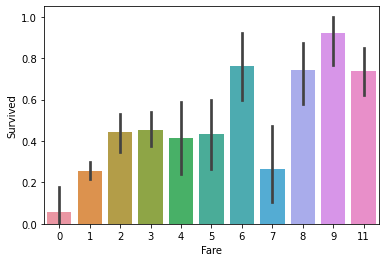

In [ ]:
ax = sns.barplot(x="Fare", y="Survived", data=train_df) # That's why we create new features,called 'Fare_eq'

In [ ]:
merg_df = pd.read_csv(io.BytesIO(uploaded_train['train.csv'])).append(
    pd.read_csv(io.BytesIO(uploaded_test['test.csv'])),ignore_index=True) # create Df(Train+Test) to fill NA Ages()

In [ ]:
merg_df.Name= merg_df.Name.apply(lambda x:make_group(x)) #I use median of ALL dataset,becouse we have not much data.1309 of all passanger and 419 in test dataFrame. So using median of all passenger will be more usefull
temp = merg_df.groupby(by='Name',as_index=False)['Age'].median()
temp.columns = ['Name','Median']
train_df =fill_na_age(train_df)
test_df = fill_na_age(test_df)

In [ ]:
#Create Target and Train DF
target = train_df.Survived
target
X_train = train_df.drop(columns=['Survived','PassengerId'])
test_id = test_df.PassengerId
X_test = test_df.drop(columns=['PassengerId'])

In [ ]:
X_train

,Sex,Age,isAlone,Fare,Pclass_2,Pclass_3,Cabin_Z,FareEq,Name_Miss.,Name_Mr.,Name_Mrs.,Name_Other
0,1,22,0,1,0,1,1,0,0,1,0,0
1,1,35,1,1,0,1,1,0,0,1,0,0
2,1,29,1,1,0,1,1,0,0,1,0,0
3,1,54,1,5,0,0,0,1,0,1,0,0
4,1,20,1,1,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,44,1,4,0,0,1,1,0,0,0,1
887,0,49,1,3,0,0,0,1,0,0,0,1
888,1,38,1,0,0,0,1,0,0,0,0,1
889,1,28,0,3,1,0,1,1,0,0,0,1


In [ ]:
%%time
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=5)
param_test2 = {
   'bootstrap': [True,False],
  'class_weight':['balanced', 'balanced_subsample'],
 'max_depth': range(2,10,1),
 'criterion': ['gini','entropy'],
 'max_features': ['auto','log2'],
 'min_samples_leaf': [1, 2, 4,7],
 'min_samples_split': [2, 3, 5,7],
 'n_estimators': range(20,140,20)
              }
gsearch1 = GridSearchCV(estimator =   RandomForestClassifier(), 
 param_grid = param_test2,verbose=4,n_jobs=-1,cv=cv).fit(X_train,target)
print(gsearch1.best_params_)

Fitting 3 folds for each of 12288 candidates, totalling 36864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1214 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2390 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3124 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3958 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5918 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 7044 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 8270 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 9592 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 11014 tasks      |

{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
CPU times: user 1min 55s, sys: 2.7 s, total: 1min 58s
Wall time: 59min 41s


In [ ]:
#THIS IS NOT MY CODE. I TOOK IT FROM INTERNET TO CHECK SOME PROBLEMS(overfitting)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    'Generate a simple plot of the test and training learning curve'
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')
    return plt

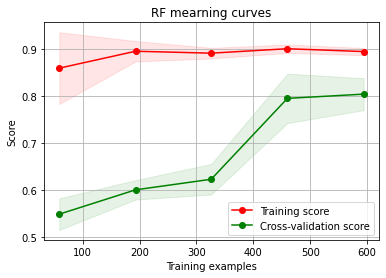

In [ ]:
#THIS IS NOT MY CODE. I TOOK IT FROM INTERNET TO CHECK SOME PROBLEMS(overfitting)
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,  learning_curve
test = gsearch1.best_estimator_
g = plot_learning_curve(gsearch1.best_estimator_,"RF mearning curves",X_train,target,cv=cv)

In [ ]:
 #Tuning hyperparams and some Scores
 from sklearn.metrics import accuracy_score
 print(gsearch1.best_params_, gsearch1.best_score_,accuracy_score(target, gsearch1.predict(X_train)))
 #XGBClassifier(objective= 'binary:logistic')
 #{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 160} 0.875 0.9102132435465768 CV = 4
 #{'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 110} 0.8611111111111112 0.9147025813692481 CV = 4
 #{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100} 0.8755555555555556 0.9046015712682379 CV = 5
 #{'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100} 0.8422222222222222 0.8799102132435466 CV = 5 add new colomns (isAlone)
 #{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 130} 0.8777777777777779 0.9090909090909091 CV = 5 add new colomns (isAlone)
 #{'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 110} 0.8481481481481481 0.9012345679012346 CV =3 
 #{'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 150} 0.8407407407407407 0.9135802469135802 cv = 3
 #{'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 130} 0.8422222222222222 0.9405162738496072 CV = 10
 #{'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 90} 0.8638888888888888 0.8922558922558923 CV =4
 #{'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 130} 0.8861111111111111 0.9001122334455668 CV=4
 #{'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 130} 0.85 0.9012345679012346 CV = 10 Результат 0.77033
 #{'learning_rate': 0.6, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 70} 0.868888888888889 0.898989898989899 CV = 10 0.76794
#Random Treee
#{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100} 0.8355555555555556 0.8900112233445566 CV = 10 BEST SCORE = 0.78229
#{'bootstrap': False, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} 0.8222222222222223 0.8619528619528619  cv=4 SCORE = 0.78229
#{'bootstrap': False, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 0.8444444444444444 0.8720538720538721 cv = 2 BEST SCORE OVER ALL 0.79425
#{'bootstrap': False, 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 130} 0.8444444444444444 0.9270482603815937 cv=1 score 0.77990
#{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 140} 0.8777777777777778 0.9147025813692481 CV=2 0.76315
#{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 80} 0.793462488033456 0.7822671156004489
#{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 80} 0.793462488033456 0.7822671156004489 CV=2 0.75119
#{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 180} 0.7654320987654321 0.7822671156004489 CV=3 0.75119
#{'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 140} 0.8136897264070136 0.8945005611672279 CV=2 0.77511
#Random Treee Equality Features
#{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 80} 0.8383770287141074 0.8967452300785634 CV = 10 0.77272
#{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 80} 0.8125736887186981 0.920314253647587 CV=2 0.78229
#{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120} 0.8350168350168351 0.8900112233445566 CV=3 0.77272
#'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 160} 0.8372318506847655 0.8832772166105499 CV=4  0.77511
#LogicReg
#{'C': 1.2915496650148828, 'class_weight': None, 'max_iter': 110, 'penalty': 'l2', 'solver': 'lbfgs'} 0.8024814833476093 0.8215488215488216 CV=2 0.76555
#{'C': 1.2915496650148828, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'} 0.8125717852684143 0.8181818181818182 CV=10 0.75837
#XGBOST
#{'gamma': 0.5, 'learning_rate': 0.43651583224016566, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 110, 'scale_pos_weight': 1, 'subsample': 0.7079457843841379} 0.8305361011739809 0.9270482603815937 CV=2 0.75358
#{'gamma': 1, 'learning_rate': 0.43651583224016566, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 70, 'scale_pos_weight': 1, 'subsample': 0.5011872336272722} 0.8507615480649188 0.8922558922558923 CV = 10 0.76555
#{'gamma': 0, 'learning_rate': 0.09549925860214355, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 110, 'scale_pos_weight': 1, 'subsample': 0.7079457843841379} 0.8451070240411775 0.8956228956228957 CV=5  0.77272
#{'gamma': 0, 'learning_rate': 0.43651583224016566, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 110, 'scale_pos_weight': 1, 'subsample': 0.7079457843841379} 0.840628507295174 0.9001122334455668 CV=4
#NEW DATASET CABIN Y AND CABIN Z
#XGBBOST
#{'gamma': 0, 'learning_rate': 0.43651583224016566, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 90, 'scale_pos_weight': 1, 'subsample': 0.5011872336272722} 0.8350178868342822 0.8900112233445566 CV=2 0.72966
#{'gamma': 0, 'learning_rate': 0.09549925860214355, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.5011872336272722} 0.8428661100998054 0.8877665544332211 CV=5 0.77751
#{'gamma': 1, 'learning_rate': 0.43651583224016566, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 110, 'scale_pos_weight': 1, 'subsample': 0.7079457843841379} 0.8462921348314607 0.898989898989899 CV=10 0.76794
#RandomTree
#{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 120} 0.8361057058565062 0.9158249158249159 CV=5 0.77511
#{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20} 0.8148183604574999 0.8933782267115601 CV=2 0.77272
#{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20} 0.8271604938271606 0.8877665544332211 CV=3 0.68421

{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20} 0.8271604938271606 0.8877665544332211


In [ ]:

answer = gsearch1.predict(X_test)
final_anw = pd.concat([pd.Series(answer),test_id,],axis=1)
columns = ['Survived','PassengerId']
final_anw = final_anw.sort_values(by=['PassengerId'])
final_anw = final_anw.reset_index(drop=True)
final_anw = final_anw[['PassengerId',0]]
final_anw.columns=['PassengerId','Survived']
final_anw

,PassengerId,Survived
0,892,1
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1


In [ ]:
#Download Answer to Google Drive
from google.colab import drive
drive.mount('drive')
final_anw.to_csv('Done190.csv',index=False)
!cp Done190.csv 'drive/My Drive/rep/'

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
#Tuning graveyard:
#Random Tree
# 'bootstrap': [True,False],
#   'class_weight':['balanced', 'balanced_subsample'],
#  'max_depth': range(2,10,1),
#  'criterion': ['gini','entropy'],
#  'max_features': ['auto'],
#  'min_samples_leaf': [1, 2, 4,7],
#  'min_samples_split': [2, 3, 5,7],
#  'n_estimators': range(80,190,20)
#XGBBOST
# 'max_depth':range(3,8,1),
#      'min_child_weight':range(1,6,2),
#      'learning_rate':np.logspace(-3,0.3,num=6),
#      'n_estimators':range(70,170,20),
#      'subsample': np.logspace(-0.3,0,num=3),
#      'gamma': [0,0.5,1,6,10],
#      'scale_pos_weight':[1,1.5,2]